<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

# Week 9: DBSCAN Clustering

In this lab we'll implement the DBSCAN algorithm for clustering in 3 steps: 

- Get point neighbors within epsilon distance.
- Label a point as 'core', 'border', or 'noise'.
- Traverse a cluster, starting at a core point.
- Combine the above to implement DBSCAN. 

</div>

## Description of DBSCAN process

DBSCAN is a clustering method which assigns points to clusters based on continuous regions
of point density above a given threshold. 

We will use the variables 'epsilon' and min_pts to determine if a point belongs to a local 
high-density region. 

Here is an outline of the DBSCAN algorithm:

1. For each point in the dataset, we:  	
    a. Compute the epsilon neighbourhood of the point;  
    b. Classify the point as core, border or noise, depending on the number of neighbours.

2. For each **core** point, *p*, that is **not** assigned a cluster id, we explore the points in the epsilon neighbourhood as follows:  
    a. Assign the point *p* the current cluster id;  
    b. Move to the next point in the epsilon neighbourhood, *n*, and if that point is of type 'core' or 'border' then we assign the same cluster id.  
        i. If *n* is also a core point, we repeat step 2b to explore the neighbouring points of *n*.  
        ii. If *n* is not a core point, we move on to the next neighbour of *p* and repeat step 2.

3. Step 2 is repeated until all core points are assigned a cluster id.

*For more information on DBSCAN you can review [Ester et al. 1996](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf) here.*



## Representing Points


Today we will represent a single point using [python dataclasses](https://www.datacamp.com/tutorial/python-data-classes). This is similar to a 'named tuple' in other languages. <br>
You can access the attributes of these classes using '.' (dot notation). 

Each point is initialised with a unique id <small>`point.uid`</small>, an x-coordinate <small>`point.x`</small>, and a y-coordinate <small>`point.y`</small>. 

The point type <small>`point.ptype`</small>, one of 'core' | 'border' | 'noise', starts off as None. <br>
During DBSCAN we will update this attribute. 

The final cluster assignment <small>`point.cluster`</small>, starts off as None. <br>
During DBSCAN we will update this attribute. 

Read then run the cell below to learn how our data will be represented. 

In [1]:
from typing import Optional
from dataclasses import dataclass 

@dataclass
class Datapoint:
    uid: int                # each point has a unique id. 
    x: float                # the x coordinate of this point
    y: float                # the y coordinate of this point
    ptype: Optional[str]    # the type of point. initialised as None. will update later to 'core', 'border', or 'noise'. 
    cluster: Optional[int]  # the final cluster assignment for this point. initialised as None. will update later. 

point1 = Datapoint(uid=0, x=2.2, y=2.0, ptype=None, cluster=None)
point2 = Datapoint(uid=1, x=0.7, y=1.1, ptype=None, cluster=None)

print('\n--- point1 ---')
print(point1)
print(point1.uid)
print(point1.x)
print(point1.cluster)

print("\n--- updating point2 'ptype' attribute ---")
print(f'before = {point2.ptype}')
point2.ptype = 'core'
print(f'after  = "{point2.ptype}"')


--- point1 ---
Datapoint(uid=0, x=2.2, y=2.0, ptype=None, cluster=None)
0
2.2
None

--- updating point2 'ptype' attribute ---
before = None
after  = "core"


## Generating Data

Run the cell below to randomly generate a 'moons' dataset with noise. 

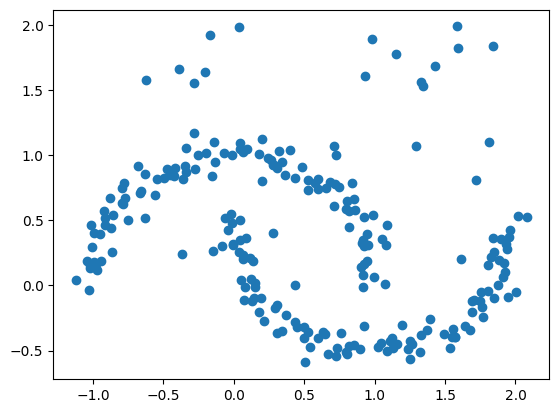

In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt 
import numpy as np

# Generate curved testing data
x, label = make_moons(n_samples=200, noise=0.07, random_state=19)

# Add background noise and reformat to tuples
background = np.random.uniform(low=[-1,0],high=[2,2],size=(30,2))
points_array = np.concatenate([x,background])
data = [tuple(p) for p in points_array]

# Initialise Datapoints
datapoints = []
uid = 0
for x, y in points_array:
    point = Datapoint(uid=uid, x=x, y=y, ptype=None, cluster=None)
    datapoints.append(point)
    uid += 1

# Inspect data
x_values = [p.x for p in datapoints]
y_values = [p.y for p in datapoints]
plt.scatter(x_values, y_values)

A core part of DBSCAN is using euclidean distance to judge how 'far' two points are from each other. 

A helper function is provided below to calculate this.

In addition, we have provided a plotting function to view your DBSCAN outputs. 

In [3]:
# run this cell to load helper functions for today's tutorial. 

def euclidean_distance(point1: Datapoint, point2: Datapoint) -> float:
    """
    Assuming that a and b are each tuples representing points, 
    calculate the euclidean distance beween them.
    """
    return np.linalg.norm(np.array([point1.x, point1.y]) - np.array([point2.x, point2.y])) # type: ignore

def plot_dbscan(
    datapoints: list[Datapoint], 
    test_point: Optional[Datapoint]=None, 
    eps: Optional[float]=None
    ) -> None:

    import matplotlib.colors as mcolors
    import matplotlib.lines as mlines
    colors = list(mcolors.TABLEAU_COLORS.values())
    cluster_ids = set([p.cluster for p in datapoints])
    legend_data = []

    plt.figure(figsize=(8, 8))
    ax = plt.axes((0.1, 0.1, 0.8, 0.8), xlim=(-1.2, 2.2), ylim=(-1.2, 2.2))
    for clust, color in zip(cluster_ids, colors):
        label_clust = mlines.Line2D([], [], color=color, label=f'cluster id: {clust}')
        legend_data.append(label_clust)
        points = [p for p in datapoints if p.cluster == clust]
        x_values = [p.x for p in points]
        y_values = [p.y for p in points]
        ax.scatter(x_values, y_values, color=color)

    if test_point:
        ax.scatter(test_point.x, test_point.y, s=120, color='black', marker='x', label='test point')
        label_x = mlines.Line2D([], [], color='black', label='test point')
        legend_data.append(label_x)
        if eps is not None:
            points_whole_ax = 8 * 0.8 * 72    # 1 point = dpi / 72 pixels
            radius = eps
            points_radius = 2 * radius / 3.4 * points_whole_ax
            ax.scatter(test_point.x, test_point.y, s=points_radius**2, facecolors='none', edgecolors='r')
            label_eps = mlines.Line2D([], [], color='r', label='eps boundary')
            legend_data.append(label_eps)
        plt.title(f'Point type: {test_point.ptype}')
    
    plt.legend(handles=legend_data)
    plt.show()



<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<h3>Exercise 1</h3>
    
<b>Challange:</b> Write a function which returns a list of indices of data points that occur within a maximum of epsilon distance of a query point.
    
Use provided function `euclidean_distance()` to find distance between two points.
    
- [ ] Inputs: 
    - A list of data point x,y coordinates (as tuples); 
    - a query data point (tuple); 
    - and an epsilon distance value (float).
- [ ] Return: List of indices of datapoints within eps distance of the query point
    
</div>


In [4]:
def get_neighbours(all_points: list[Datapoint], point: Datapoint, eps: float):
    """
    Find all data points that occur within a maximum of eps distance of point p.
    Return as list of index positions corresponding to each neighbour in the input data point list.
    """
    ### BEGIN SOLUTION
    neighbours = []
    for i in range(len(all_points)):
        if euclidean_distance(all_points[i], point) <= eps:
            neighbours.append(all_points[i])
    
    return neighbours
    ### END SOLUTION

Neighbours:
Datapoint(uid=2, x=0.4364083154467885, y=0.826418083224656, ptype=None, cluster=None)
Datapoint(uid=10, x=0.5752759083966145, y=0.7872305895497588, ptype=None, cluster=None)
Datapoint(uid=33, x=0.5294371529506441, y=0.7287242289029817, ptype=None, cluster=None)
Datapoint(uid=34, x=0.656104843682898, y=0.745375956192758, ptype=None, cluster=None)
Datapoint(uid=64, x=0.6862562815946758, y=0.7935742806485325, ptype=None, cluster=None)
Datapoint(uid=71, x=0.7188383148329568, y=0.779303817153433, ptype=None, cluster=None)
Datapoint(uid=119, x=0.5999946171898114, y=0.813972200732631, ptype=None, cluster=None)
Datapoint(uid=127, x=0.524681660474182, y=0.8055731329157847, ptype=None, cluster=None)
Datapoint(uid=150, x=0.5947824838710556, y=0.740128516618745, ptype=None, cluster=None)


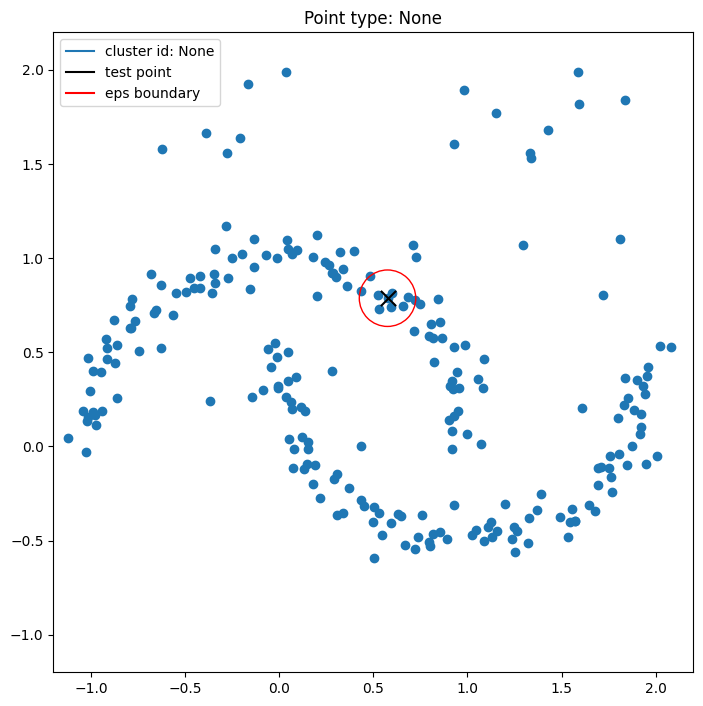

In [5]:
test_point = datapoints[10]
neighbours = get_neighbours(datapoints, test_point, eps=0.15)
print('Neighbours:')
for n in neighbours:
    print(n)
plot_dbscan(datapoints, test_point, eps=0.15)

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<h3>Exercise 2</h3>
    
<b>Challange:</b> Write a function which labels a set of data points as 'core', 'border', or 'noise'.
    
- [ ] Inputs: 
    - List of datapoints (list); 
    - min point value (int); 
    - epsilon value (float)
- [ ] Return: A list of labels in corresponding order to data point list.
    
</div>


In [6]:
def get_point_type(all_points: list[Datapoint], point: Datapoint, min_pts: int, eps: float) -> str:
    """
    Identifies the 'type' of a given Datapoint. 
    
    Return point label as: 
    - 'core' if number of points within eps radius >= min_pts, including self.
    - 'border' if within eps distance of a core point
    - 'noise' if not within eps distance of a core point

    Use your 'get_neighbours()' function to help. 
    """
    ### BEGIN SOLUTION
    # get neighbours  
    neighbours = get_neighbours(all_points, point, eps)
    
    # is this a core point? 
    if len(neighbours) +1 >= min_pts: 
        return 'core'
    
    # is this a border point?
    for p in neighbours:
        p_neighbours = get_neighbours(all_points, p, eps) 
        if len(p_neighbours) >= min_pts:
            return 'border'
    
    # if haven't returned yet, this point is noise. 
    return 'noise'
    ### END SOLUTION


point 0


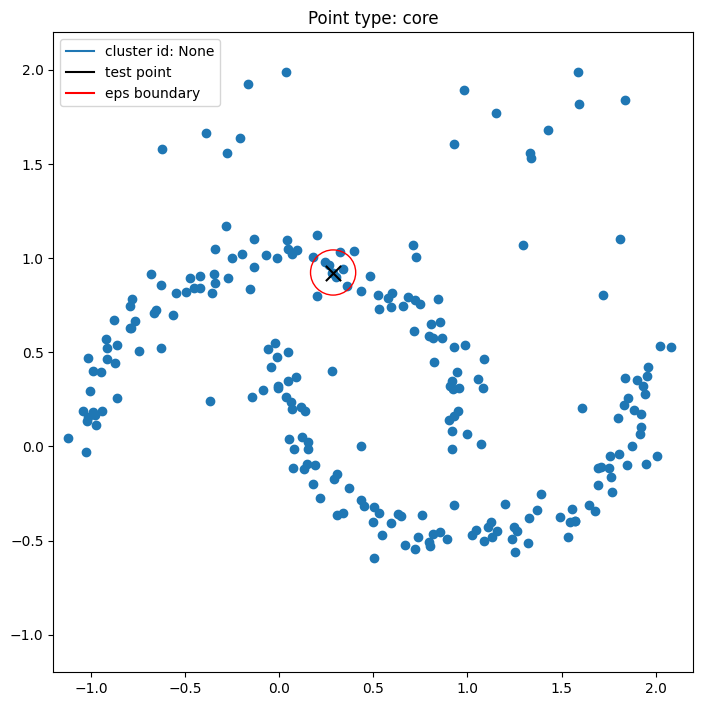

point 1


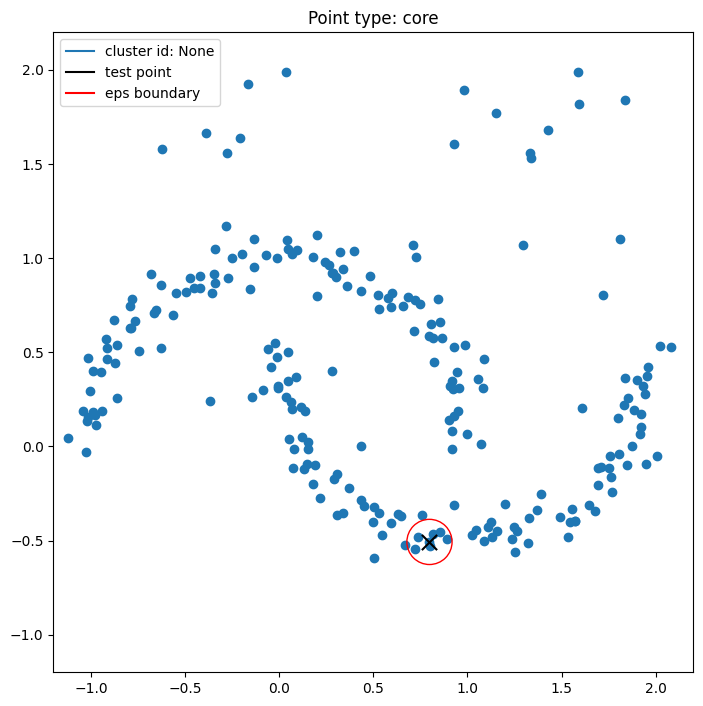

point 6


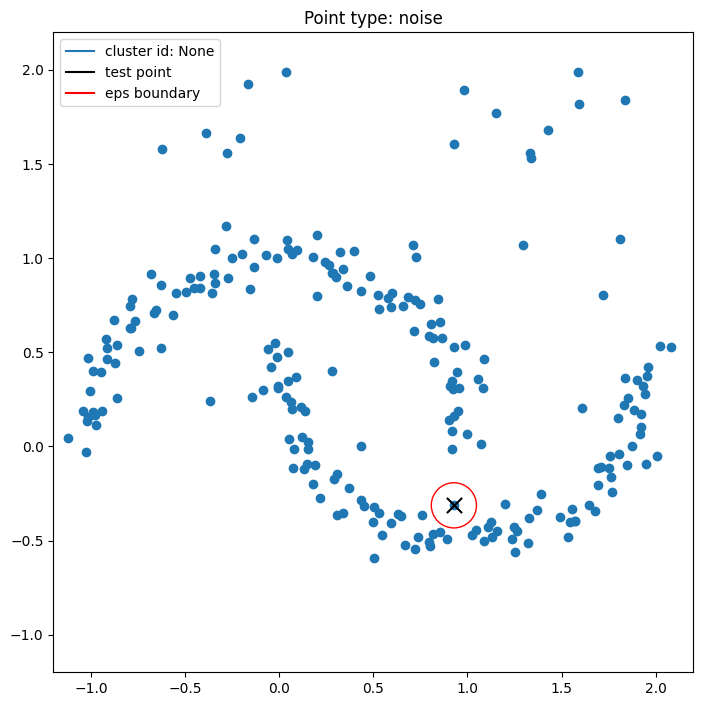

point 11


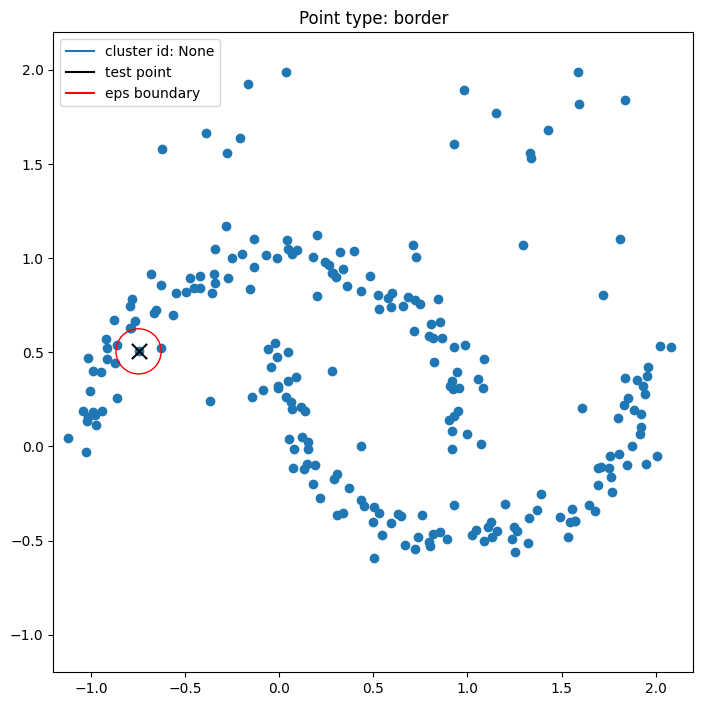

In [7]:
# should hopefully assign [core, core, noise, border]
for i in [0, 1, 6, 11]:
    print(f'point {i}')
    datapoints[i].ptype = get_point_type(datapoints, datapoints[i], min_pts=4, eps=0.12)
    plot_dbscan(datapoints, test_point=datapoints[i], eps=0.12)

# Note: check the plot title to view the assigned point.ptype.

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
    
<h3>Exercise 3</h3>

<b>Challenge:</b> Write a recursive function that traverses from a given core point.
    
- [ ] Take as input: 
    - A list of all datapoints (list)
    - The current 'core' point (Datapoint)
    - An epsilon value (float)
    - A minimum points value (int)
    - A unique cluster id (int)

Assume that each point already has a valid 'ptype' attribute (either core, border, or noise). 

Returning an output is not required, as we are simply updating the cluster attribute for a given point. <br>
The point will be permanently altered - ie if we look at the same point again later, the cluster attribute will already be assigned. 

You will need to:
1. Assign the cluster_id to the core point 'cluster' attribute. 
2. Handle neighbouring points:
    - If the neighbour point already has a valid 'cluster' assigned, ignore.
    - If the neighbour point is 'noise', ignore. 
    - If the neighbour point is 'core', <small>`traverse()`</small> from this next core node. 
    - If the neighbour point is 'border', update its 'cluster' attribute and continue.  

</div>




In [8]:
def traverse(all_points: list[Datapoint], point: Datapoint, eps: float, cluster_id: int) -> None:
    """
    Assigns cluster_id to point.cluster.
    Handles neighbouring points in the following manner: 
        - If the neighbour point already has a valid 'cluster' assigned, ignore.
        - If the neighbour point is 'noise', ignore. 
        - If the neighbour point is 'core', <small>`traverse()`</small> from this next core node. 
        - If the neighbour point is 'border', update its 'cluster' attribute and continue.  
    """
    ### BEGIN SOLUTION
    # add core point to cluster
    point.cluster = cluster_id
    
    # get neighbour points
    neighbours = get_neighbours(all_points, point, eps)
    
    for n in neighbours:
        # already discovered
        if n.cluster is not None or n.ptype == 'noise':
            continue 
        
        # if core, traverse
        elif n.ptype == 'core':
            traverse(all_points, n, eps, cluster_id)

        # if border, update cluster & continue
        elif n.ptype == 'border':
            n.cluster = cluster_id
        
        else:
            raise RuntimeError
    ### END SOLUTION


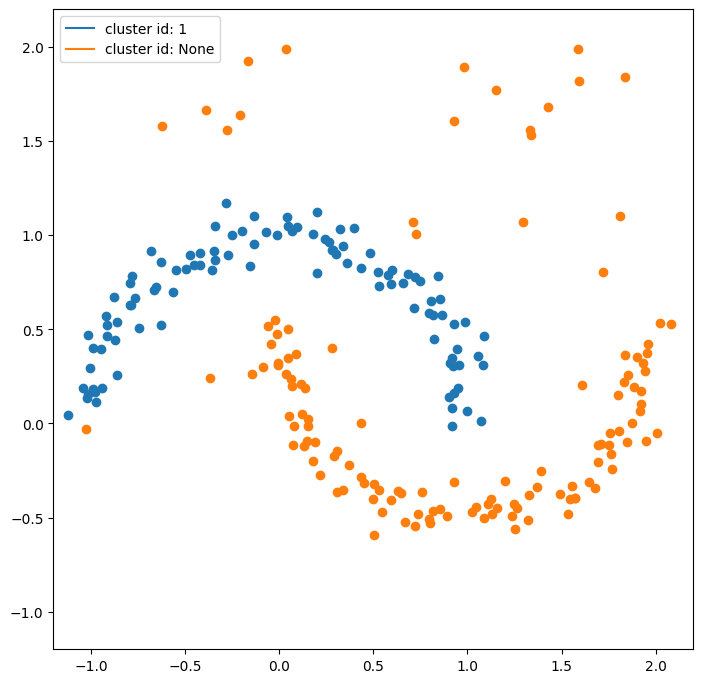

In [9]:
# resetting point data
for point in datapoints:
    point.ptype = get_point_type(datapoints, point, min_pts=4, eps=0.15)
    point.cluster = None

# traverse and plot
core_point = datapoints[0]
traverse(datapoints, core_point, eps=0.15, cluster_id=1)
plot_dbscan(datapoints)


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
    
<h3>Exercise 4</h3>

<b>Challange:</b> Write a function which performs DBSCAN. 
    
- [ ] Take as input: 
    - A list of datapoints (list)
    - An epsilon value (float)
    - A minimum points value (int)

Returning an output is not required, as we are simply updating the cluster attribute for a given point.

**Process**

For each point in datapoints:
- If the point already has a 'cluster' assignment, ignore.
- If noise point, update its 'cluster' as -1 (we'll use -1 to represent the noise cluster). 
- If border point, ignore.
- If core point
    - Create a new cluster_id (int).
    - <small>`traverse()`</small> from this point, supplying the new cluster_id.

</div>


In [10]:
def dbscan(datapoints: list[Datapoint], min_pts: int, eps: float) -> None:
    """
    performs DBSCAN clustering. 
    """
    for point in datapoints:
        point.ptype = get_point_type(datapoints, point, min_pts, eps)

    ### BEGIN SOLUTION
    cluster_id = 0
    for point in datapoints:
        
        # ignore if cluster already assigned. 
        if point.cluster is not None:
            continue

        # noise point
        elif point.ptype == 'noise':
            point.cluster = -1

        # border point:
        elif point.ptype == 'border':
            continue 

        # core point
        elif point.ptype == 'core':
            cluster_id += 1
            traverse(datapoints, point, eps, cluster_id)
        
        else:
            raise RuntimeError
    ### END SOLUTION
    

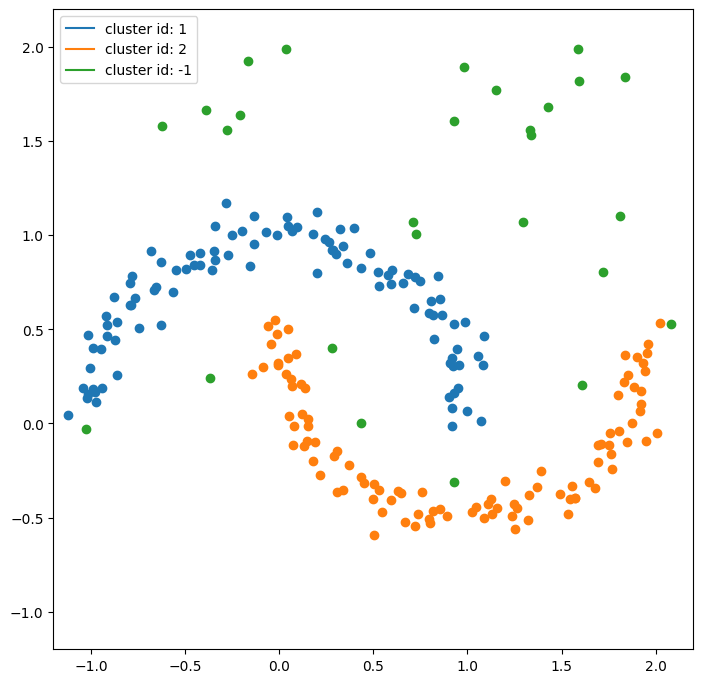

In [11]:
# resetting point data
for point in datapoints:
    point.ptype = None
    point.cluster = None

# DBSCAN and plot
dbscan(datapoints, min_pts=4, eps=0.15)
plot_dbscan(datapoints)